In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from decimal import Decimal
from typing import List, Tuple
from warnings import warn

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml
from ogb.nodeproppred import PygNodePropPredDataset

import tqdm
tqdm.tqdm.pandas()

In [4]:
from notebooks import mpl_latex

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [5]:
mpl_latex.enable_production_mode()

In [6]:
from rgnn_at_scale.data import prep_graph, split
from rgnn_at_scale.attacks import create_attack, SPARSE_ATTACKS
from rgnn_at_scale.helper.io import Storage
from rgnn_at_scale.models import DenseGCN, GCN
from rgnn_at_scale.train import train
from rgnn_at_scale.helper.utils import accuracy

# Effectiveness for different block sizes

In [7]:
dataset = 'ogbn-arxiv'
binary_attr = False
attack = 'PRBCD'
seed = 0
device = 0
surrogate_params = {
    'n_filters': [256, 256],
    'dropout': 0.5,
    'with_batchnorm': True,
    'train_params': {
        'lr': 1e-2,
        'weight_decay': 0,
        'patience': 300,
        'max_epochs': 3000
    }
}
attack_params = {
    'keep_heuristic': 'WeightOnly',
    'loss_type': 'tanhMargin'
}
search_space_sizes = [350_000, 600_000, 1_000_000, 10_000_000, 20_000_000]
epsilon = 0.1
display_steps = 10

torch.manual_seed(seed)
np.random.seed(seed)

In [8]:
data = prep_graph(dataset, device='cpu', binary_attr=binary_attr, make_undirected=True, return_original_split=dataset.startswith('ogbn'))
if len(data) == 3:
    attr, adj, labels = data
    idx_train, idx_val, idx_test = data.split(labels.cpu().numpy())
else:
    attr, adj, labels, split = data
    idx_train, idx_val, idx_test = split['train'], split['valid'], split['test']
n_features = attr.shape[1]
n_classes = int(labels.max() + 1)

In [9]:
gcn = GCN(n_classes=n_classes, n_features=n_features, **surrogate_params).to(device)
train(model=gcn, attr=attr.to(device), adj=adj.to(device), labels=labels.to(device),
      idx_train=idx_train, idx_val=idx_val, display_step=display_steps, **surrogate_params['train_params'])

Training...:   0%|          | 0/3000 [00:00<?, ?it/s]

([3.6803221702575684,
  3.3011386394500732,
  3.1253364086151123,
  3.091355800628662,
  3.092853546142578,
  3.118133068084717,
  3.1171462535858154,
  2.989225149154663,
  2.860402822494507,
  2.7737905979156494,
  2.7171685695648193,
  2.644099473953247,
  2.5090339183807373,
  2.3906261920928955,
  2.2983908653259277,
  2.2454802989959717,
  2.1638426780700684,
  2.072758197784424,
  2.005610227584839,
  1.9740118980407715,
  1.914901614189148,
  1.8531126976013184,
  1.8153612613677979,
  1.7695488929748535,
  1.7240490913391113,
  1.6937404870986938,
  1.6799681186676025,
  1.6358236074447632,
  1.6089063882827759,
  1.5808699131011963,
  1.548453688621521,
  1.5245743989944458,
  1.503406047821045,
  1.48654043674469,
  1.472662329673767,
  1.4494519233703613,
  1.426102638244629,
  1.4095126390457153,
  1.390886664390564,
  1.3782545328140259,
  1.3626352548599243,
  1.3563464879989624,
  1.3410420417785645,
  1.3343013525009155,
  1.318767786026001,
  1.3024731874465942,
  1.2

In [10]:
with torch.no_grad():
    pred_logits_surr = gcn(attr.to(device), adj.to(device))
accuracy(pred_logits_surr, labels.to(device), idx_test)

0.6984136700630188

# Compensate block size with more epochs

In [11]:
search_space_sizes = [1_000_000, 2_000_000, 10_000_000]
line_styles = ['-', '--', ':']
epochs = [1000, 500, 100]

results = []
for epoch, search_space_size in zip(epochs, search_space_sizes):
    temp_attack_params = dict(attack_params)
    temp_attack_params['search_space_size'] = search_space_size
    temp_attack_params['epochs'] = epoch
    temp_attack_params['fine_tune_epochs'] = 0
    temp_attack_params['with_early_stropping'] = False
    adversary = create_attack(attack, adj=adj, attr=attr, binary_attr=False, labels=labels, make_undirected=True,
                              model=gcn, idx_attack=idx_test, device=device, data_device=device, **temp_attack_params)

    m = adj.nnz() / 2
    torch.manual_seed(seed)
    np.random.seed(seed)

    n_perturbations = int(round(epsilon * m))
    adversary.attack(n_perturbations)
    
    results.append(adversary.attack_statistics)

  0%|          | 1/1000 [00:00<07:28,  2.23it/s]


Epoch: 0 Loss: -0.3935643136501312 Accuracy: 69.699 %



  2%|▏         | 21/1000 [00:08<06:49,  2.39it/s]


Epoch: 20 Loss: -0.038684114813804626 Accuracy: 49.240 %



  4%|▍         | 41/1000 [00:17<06:55,  2.31it/s]


Epoch: 40 Loss: 0.08152090013027191 Accuracy: 43.553 %



  6%|▌         | 61/1000 [00:25<06:26,  2.43it/s]


Epoch: 60 Loss: 0.14515241980552673 Accuracy: 40.666 %



  8%|▊         | 81/1000 [00:34<06:35,  2.32it/s]


Epoch: 80 Loss: 0.18847140669822693 Accuracy: 38.613 %



 10%|█         | 101/1000 [00:43<06:40,  2.25it/s]


Epoch: 100 Loss: 0.2194346934556961 Accuracy: 37.308 %



 12%|█▏        | 121/1000 [00:51<06:08,  2.38it/s]


Epoch: 120 Loss: 0.24319157004356384 Accuracy: 36.224 %



 14%|█▍        | 141/1000 [01:00<05:53,  2.43it/s]


Epoch: 140 Loss: 0.2623242139816284 Accuracy: 35.399 %



 16%|█▌        | 161/1000 [01:08<06:06,  2.29it/s]


Epoch: 160 Loss: 0.2789028286933899 Accuracy: 34.638 %



 18%|█▊        | 181/1000 [01:17<05:41,  2.40it/s]


Epoch: 180 Loss: 0.2927076816558838 Accuracy: 34.023 %



 20%|██        | 201/1000 [01:25<05:12,  2.56it/s]


Epoch: 200 Loss: 0.3045010268688202 Accuracy: 33.525 %



 22%|██▏       | 221/1000 [01:33<05:26,  2.38it/s]


Epoch: 220 Loss: 0.3146107494831085 Accuracy: 33.068 %



 24%|██▍       | 241/1000 [01:41<05:19,  2.37it/s]


Epoch: 240 Loss: 0.32381120324134827 Accuracy: 32.665 %



 26%|██▌       | 261/1000 [01:50<05:27,  2.26it/s]


Epoch: 260 Loss: 0.3319331109523773 Accuracy: 32.292 %



 28%|██▊       | 281/1000 [01:58<04:57,  2.41it/s]


Epoch: 280 Loss: 0.3388826847076416 Accuracy: 32.017 %



 30%|███       | 301/1000 [02:07<04:53,  2.38it/s]


Epoch: 300 Loss: 0.3455101549625397 Accuracy: 31.700 %



 32%|███▏      | 321/1000 [02:15<04:53,  2.31it/s]


Epoch: 320 Loss: 0.35158059000968933 Accuracy: 31.455 %



 34%|███▍      | 341/1000 [02:23<04:16,  2.57it/s]


Epoch: 340 Loss: 0.357249915599823 Accuracy: 31.212 %



 36%|███▌      | 361/1000 [02:32<04:23,  2.43it/s]


Epoch: 360 Loss: 0.36249345541000366 Accuracy: 30.965 %



 38%|███▊      | 381/1000 [02:40<04:29,  2.30it/s]


Epoch: 380 Loss: 0.36744484305381775 Accuracy: 30.761 %



 40%|████      | 401/1000 [02:49<04:06,  2.43it/s]


Epoch: 400 Loss: 0.37200865149497986 Accuracy: 30.550 %



 42%|████▏     | 421/1000 [02:57<03:56,  2.45it/s]


Epoch: 420 Loss: 0.3757774233818054 Accuracy: 30.389 %



 44%|████▍     | 441/1000 [03:05<04:00,  2.32it/s]


Epoch: 440 Loss: 0.37972792983055115 Accuracy: 30.220 %



 46%|████▌     | 461/1000 [03:14<03:56,  2.27it/s]


Epoch: 460 Loss: 0.38336116075515747 Accuracy: 30.076 %



 48%|████▊     | 481/1000 [03:23<03:34,  2.42it/s]


Epoch: 480 Loss: 0.3870446979999542 Accuracy: 29.901 %



 50%|█████     | 501/1000 [03:31<03:19,  2.50it/s]


Epoch: 500 Loss: 0.3906461298465729 Accuracy: 29.727 %



 52%|█████▏    | 521/1000 [03:39<03:30,  2.27it/s]


Epoch: 520 Loss: 0.3939996063709259 Accuracy: 29.576 %



 54%|█████▍    | 541/1000 [03:48<03:23,  2.26it/s]


Epoch: 540 Loss: 0.39681345224380493 Accuracy: 29.449 %



 56%|█████▌    | 561/1000 [03:57<03:17,  2.22it/s]


Epoch: 560 Loss: 0.3999771773815155 Accuracy: 29.294 %



 58%|█████▊    | 581/1000 [04:06<03:09,  2.21it/s]


Epoch: 580 Loss: 0.4029112458229065 Accuracy: 29.157 %



 60%|██████    | 601/1000 [04:15<03:02,  2.18it/s]


Epoch: 600 Loss: 0.4056025743484497 Accuracy: 29.046 %



 62%|██████▏   | 621/1000 [04:24<02:44,  2.31it/s]


Epoch: 620 Loss: 0.40848803520202637 Accuracy: 28.912 %



 64%|██████▍   | 641/1000 [04:33<02:41,  2.23it/s]


Epoch: 640 Loss: 0.4110349416732788 Accuracy: 28.792 %



 66%|██████▌   | 661/1000 [04:42<02:39,  2.12it/s]


Epoch: 660 Loss: 0.41353970766067505 Accuracy: 28.688 %



 68%|██████▊   | 681/1000 [04:50<02:08,  2.47it/s]


Epoch: 680 Loss: 0.4160497784614563 Accuracy: 28.574 %



 70%|███████   | 701/1000 [04:59<02:10,  2.29it/s]


Epoch: 700 Loss: 0.41823551058769226 Accuracy: 28.461 %



 72%|███████▏  | 721/1000 [05:07<02:03,  2.27it/s]


Epoch: 720 Loss: 0.4204345941543579 Accuracy: 28.369 %



 74%|███████▍  | 741/1000 [05:16<01:51,  2.33it/s]


Epoch: 740 Loss: 0.42248743772506714 Accuracy: 28.286 %



 76%|███████▌  | 761/1000 [05:25<01:52,  2.13it/s]


Epoch: 760 Loss: 0.4246918857097626 Accuracy: 28.163 %



 78%|███████▊  | 781/1000 [05:34<01:40,  2.18it/s]


Epoch: 780 Loss: 0.42733263969421387 Accuracy: 28.027 %



 80%|████████  | 801/1000 [05:43<01:30,  2.20it/s]


Epoch: 800 Loss: 0.4302400052547455 Accuracy: 27.887 %



 82%|████████▏ | 821/1000 [05:53<01:20,  2.22it/s]


Epoch: 820 Loss: 0.4328969419002533 Accuracy: 27.745 %



 84%|████████▍ | 841/1000 [06:01<01:02,  2.53it/s]


Epoch: 840 Loss: 0.43562179803848267 Accuracy: 27.603 %



 86%|████████▌ | 861/1000 [06:10<01:03,  2.19it/s]


Epoch: 860 Loss: 0.43851330876350403 Accuracy: 27.447 %



 88%|████████▊ | 881/1000 [06:19<00:53,  2.21it/s]


Epoch: 880 Loss: 0.44131359457969666 Accuracy: 27.297 %



 90%|█████████ | 901/1000 [06:28<00:45,  2.18it/s]


Epoch: 900 Loss: 0.4441199004650116 Accuracy: 27.146 %



 92%|█████████▏| 921/1000 [06:37<00:34,  2.30it/s]


Epoch: 920 Loss: 0.44709351658821106 Accuracy: 26.982 %



 94%|█████████▍| 941/1000 [06:46<00:24,  2.42it/s]


Epoch: 940 Loss: 0.449647456407547 Accuracy: 26.848 %



 96%|█████████▌| 961/1000 [06:55<00:17,  2.20it/s]


Epoch: 960 Loss: 0.45214003324508667 Accuracy: 26.716 %



 98%|█████████▊| 981/1000 [07:04<00:08,  2.21it/s]


Epoch: 980 Loss: 0.4543767273426056 Accuracy: 26.609 %



  0%|          | 1/500 [00:00<05:22,  1.55it/s]


Epoch: 0 Loss: -0.39356428384780884 Accuracy: 68.747 %



  4%|▍         | 21/500 [00:12<05:00,  1.59it/s]


Epoch: 20 Loss: 0.048073023557662964 Accuracy: 44.545 %



  8%|▊         | 41/500 [00:25<05:01,  1.52it/s]


Epoch: 40 Loss: 0.17511068284511566 Accuracy: 38.829 %



 12%|█▏        | 61/500 [00:38<04:43,  1.55it/s]


Epoch: 60 Loss: 0.23921023309230804 Accuracy: 36.086 %



 16%|█▌        | 81/500 [00:50<03:59,  1.75it/s]


Epoch: 80 Loss: 0.2796798348426819 Accuracy: 34.298 %



 20%|██        | 101/500 [01:02<04:08,  1.61it/s]


Epoch: 100 Loss: 0.3087220788002014 Accuracy: 33.031 %



 24%|██▍       | 121/500 [01:15<04:07,  1.53it/s]


Epoch: 120 Loss: 0.3310164213180542 Accuracy: 32.060 %



 28%|██▊       | 141/500 [01:27<03:41,  1.62it/s]


Epoch: 140 Loss: 0.34849604964256287 Accuracy: 31.317 %



 32%|███▏      | 161/500 [01:39<03:33,  1.59it/s]


Epoch: 160 Loss: 0.3625517785549164 Accuracy: 30.718 %



 36%|███▌      | 181/500 [01:51<03:16,  1.62it/s]


Epoch: 180 Loss: 0.3751351833343506 Accuracy: 30.159 %



 40%|████      | 201/500 [02:04<03:24,  1.47it/s]


Epoch: 200 Loss: 0.3858812153339386 Accuracy: 29.708 %



 44%|████▍     | 221/500 [02:17<02:57,  1.57it/s]


Epoch: 220 Loss: 0.39535972476005554 Accuracy: 29.288 %



 48%|████▊     | 241/500 [02:30<02:41,  1.60it/s]


Epoch: 240 Loss: 0.40295448899269104 Accuracy: 28.951 %



 52%|█████▏    | 261/500 [02:42<02:27,  1.62it/s]


Epoch: 260 Loss: 0.41029176115989685 Accuracy: 28.628 %



 56%|█████▌    | 281/500 [02:55<02:21,  1.55it/s]


Epoch: 280 Loss: 0.4176104962825775 Accuracy: 28.292 %



 60%|██████    | 301/500 [03:08<02:01,  1.64it/s]


Epoch: 300 Loss: 0.4238787293434143 Accuracy: 28.011 %



 64%|██████▍   | 321/500 [03:20<01:55,  1.55it/s]


Epoch: 320 Loss: 0.4293100833892822 Accuracy: 27.784 %



 68%|██████▊   | 341/500 [03:33<01:42,  1.56it/s]


Epoch: 340 Loss: 0.4346051514148712 Accuracy: 27.539 %



 72%|███████▏  | 361/500 [03:46<01:31,  1.52it/s]


Epoch: 360 Loss: 0.4399438202381134 Accuracy: 27.249 %



 76%|███████▌  | 381/500 [03:59<01:13,  1.61it/s]


Epoch: 380 Loss: 0.4460355341434479 Accuracy: 26.963 %



 80%|████████  | 401/500 [04:12<01:05,  1.52it/s]


Epoch: 400 Loss: 0.45255550742149353 Accuracy: 26.597 %



 84%|████████▍ | 421/500 [04:25<00:51,  1.52it/s]


Epoch: 420 Loss: 0.4586763083934784 Accuracy: 26.291 %



 88%|████████▊ | 441/500 [04:37<00:39,  1.50it/s]


Epoch: 440 Loss: 0.4643458127975464 Accuracy: 25.994 %



 92%|█████████▏| 461/500 [04:50<00:25,  1.53it/s]


Epoch: 460 Loss: 0.4697065055370331 Accuracy: 25.712 %



 96%|█████████▌| 481/500 [05:03<00:12,  1.54it/s]


Epoch: 480 Loss: 0.475059449672699 Accuracy: 25.453 %



  1%|          | 1/100 [00:02<03:33,  2.16s/it]


Epoch: 0 Loss: -0.39356422424316406 Accuracy: 64.364 %



 21%|██        | 21/100 [00:43<02:46,  2.11s/it]


Epoch: 20 Loss: 0.2634558379650116 Accuracy: 34.103 %



 41%|████      | 41/100 [01:25<02:04,  2.11s/it]


Epoch: 40 Loss: 0.37598666548728943 Accuracy: 29.502 %



 61%|██████    | 61/100 [02:07<01:21,  2.10s/it]


Epoch: 60 Loss: 0.42712587118148804 Accuracy: 27.373 %



 81%|████████  | 81/100 [02:51<00:40,  2.12s/it]


Epoch: 80 Loss: 0.4581149220466614 Accuracy: 25.918 %



100%|██████████| 100/100 [03:31<00:00,  2.11s/it]


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


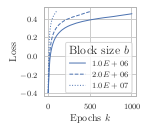

In [12]:
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)
for result, search_space_size, line_style in zip(results, search_space_sizes, line_styles):
    ax.plot(result['loss'], line_style, label=rf'${search_space_size:.1E}$')
    plt.gca().set_prop_cycle(None)
    
plt.xlabel('Epochs $k$')
plt.ylabel('Loss')    
mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_0_1_block_size_cmp_epochs_loss_no_legend', fig, close_fig=False)
plt.legend(title=f'Block size $b$')
mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_0_1_block_size_cmp_epochs_loss', fig, close_fig=False)
mpl_latex.dedicated_legend_plot(
    f'latex/assets/global_prbcd_arxiv_0_1_block_size_cmp_epochs_loss_legend',
    mod_label=lambda l: l,
    ncol=3
)    
    
plt.gcf()

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


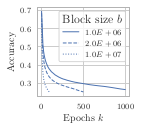

In [13]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)
for result, search_space_size, line_style in zip(results, search_space_sizes, line_styles):
    plt.plot(result['accuracy'], line_style, label=rf'${search_space_size:.1E}$')
    plt.gca().set_prop_cycle(None)
    
plt.xlabel('Epochs $k$')
plt.ylabel('Accuracy')
mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_0.1_block_size_cmp_epochs_accuracy_no_legend', fig, close_fig=False)
plt.legend(title=r'Block size $b$')
mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_0.1_block_size_cmp_epochs_accuracy', fig, close_fig=False)
mpl_latex.dedicated_legend_plot(
    f'latex/assets/global_prbcd_arxiv_0.1_block_size_cmp_epochs_accuracy_legend',
    mod_label=lambda l: l,
    ncol=3
)
    
plt.gcf()